In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import math
from copy import deepcopy

import pandas as pd

In [18]:
class DrowsinessData(Dataset):
    def __init__(self,data, trn_val_tst, transform=None):

        # split_idx1 = int(data.shape[0]*0.6)
        # split_idx2 = int(data.shape[0]*0.8)
        # if trn_val_tst == 0:
        #     #trainloader
        #     self.X = data.iloc[0:split_idx1, 0:-1].to_numpy()
        #     self.labels = data.iloc[0:split_idx1, -1].to_numpy()
        # elif trn_val_tst == 1:
        #     #valloader
        #     self.X = data.iloc[split_idx1:split_idx2, 0:-1].to_numpy()
        #     self.labels = data.iloc[split_idx1:split_idx2, -1].to_numpy()
        # else:
        #     #testloader
        #     self.X = data.iloc[split_idx1:split_idx2, 0:-1].to_numpy()
        #     self.labels = data.iloc[split_idx1:split_idx2, -1].to_numpy()

        self.X = data.iloc[:, 0:-1].to_numpy()
        self.labels = data.iloc[:, -1].to_numpy()
        self.labels[self.labels < 6.5] = 0
        self.labels[self.labels >= 6.5] = 1

        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.X[idx,:]
        label = self.labels[idx]

        # if self.transform:
        #     sample = self.transform(sample)
        sample = torch.from_numpy(sample).type(torch.float32)
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        return sample, label

In [19]:
test_data = pd.read_csv("../Features_and_Labels/30s/test_features_and_labels_30s.csv")


filter_features = {
    "mrmr": {
        "30": ['Sh_Ent1', 'MDF', 'bandPower(){}_2_beta', 'lf_hf_ratio', 'LZC(){}_1', 'MNF', 'sampEn(){}_2', 'PKF', 'ZC', 'csi', 'bandPower(){}_2_alpha', 'DFA(){}_2', 'Sh_Ent0', 'Sp_ent2', 
               'blinking_rate', 'LZC(){}_2', 'WENT', 'hjorthMobility(){}_2', 'bandPower(){}_1_beta', 'pnni_20', 'PFD(){}_1', 'hjorthComplexity(){}_2', 'bandPower(){}_2_theta', 'wave_ent2', 
               'lfnu', 'LOG', 'HFD(){}_2', 'pnni_50', 'bandPower(){}_1_alpha', 'sampEn(){}_1', 'kss']
    },
    "kbest": {
        "30": ['bandPower(){}_1_alpha', 'bandPower(){}_1_beta', 'bandPower(){}_2_theta', 'bandPower(){}_2_alpha', 'bandPower(){}_2_beta', 'hjorthMobility(){}_1', 'hjorthMobility(){}_2', 
                'hjorthComplexity(){}_2', 'sampEn(){}_1', 'sampEn(){}_2', 'DFA(){}_2', 'PFD(){}_1', 'PFD(){}_2', 'LZC(){}_1', 'LZC(){}_2', 'Sh_Ent0', 'fuzzy0', 'Sp_ent2', 'wave_ent2', 'lf_hf_ratio', 
                'lfnu', 'csi', 'LOG', 'ZC', 'MYOP', 'MNF', 'MDF', 'PKF', 'WENT', 'blinking_rate', 'kss']
    }
}

ttest_features = ["bandPower(){}_0_theta", "bandPower(){}_0_alpha", "bandPower(){}_0_beta",	"bandPower(){}_1_delta", "bandPower(){}_2_alpha", "bandPower(){}_2_beta", 
                  "hjorthActivity(){}_1", "hjorthActivity(){}_2", "hjorthMobility(){}_0", "hjorthMobility(){}_2", "hjorthComplexity(){}_0",	"hjorthComplexity(){}_2", "sampEn(){}_2", 
                  "DFA(){}_0", "DFA(){}_2", "PFD(){}_2", "LZC(){}_0", "LZC(){}_1",	"LZC(){}_2", "fuzzy0", "Sp_ent0", "EEG_kurt0",	"Sp_ent1",	"wave_ent1", "EEG_kurt1", "Multiscale2", 
                  "Sp_ent2", "wave_ent2", "EEG_mean2", "EEG_kurt2", "cvnni",	"max_hr", "nni_20",	"nni_50", "pnni_20", "pnni_50",	"range_nni", "fuzzy",	"sdsd",	"std_hr", "lf",	"hf", 
                  "lf_hf_ratio", "lfnu", "total_power",	"vlf",	"csi",	"RMS", "IEMG",	"MAV",	"LOG",	"ZC", "WAMP", "MNF", "MDF",	"PKF", "WENT", "blinking_rate",	"MAR_mean",	"vtilt_mean", 
                  "htilt_std", "kss"]

test_data = test_data.loc[:, filter_features["kbest"]["30"]]

print(test_data.shape)

test_set = DrowsinessData(test_data, trn_val_tst=2)

batch_size = 100 

testloader =  DataLoader(test_set, batch_size=batch_size, shuffle=False)

num_features = test_set.X.shape[1]

(697, 31)


In [20]:
class DrowsyNet(nn.Module):
    def __init__(self, channels_in):
        # calling the init function of the parent nn.Module
        super(DrowsyNet, self).__init__()
        
        # defining the fully connected layers
        print(channels_in)
        self.fc1 = nn.Linear(int(channels_in), int(channels_in//1.5))
        self.fc2 = nn.Linear(int(channels_in//1.5), int(channels_in//3))
        self.fc3 = nn.Linear(int(channels_in//3), 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Passing it through fc layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [21]:
#This function should perform a single evaluation epoch, it WILL NOT be used to train our model
def evaluate(model, device, loader, loss_fun):
    
    #initialise counter
    epoch_acc = 0
    total_loss = 0
    total_count = 0
    
    #Set network in evaluation mode
    #Layers like Dropout will be disabled
    #Layers like Batchnorm will stop calculating running mean and standard deviation
    #and use current stored values
    #(More on these layer types soon!)
    model.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            #Forward pass of image through network
            fx = model(x.to(device))
            y = y.type(torch.FloatTensor)
            
            #log the cumulative sum of the acc
            epoch_acc += (np.round(fx.cpu().detach()) == y).sum()
            total_count += y.shape[0]
            
            #calculate the loss
            loss = loss_fun(fx, y.to(device))
            total_loss += loss.item()
    #return the accuracy from the epoch     
    return epoch_acc / total_count, total_loss

In [22]:
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
model = DrowsyNet(num_features).to(device)
loss_fun = nn.MSELoss()

model.load_state_dict(torch.load("D:/School/Drowsiness-Detection-FYP/neural_network/classification/best_model.pt"))

test_acc, test_loss = evaluate(model, device, testloader, loss_fun)

print(test_loss, np.sqrt(test_loss), test_acc)


30
1.5684333592653275 1.2523710948697784 tensor(0.6829)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

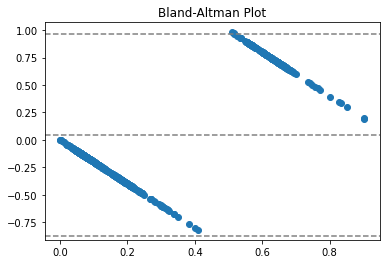

In [23]:

testloader =  DataLoader(test_set, batch_size=1, shuffle=False)
labels = []
preds = []
tp = 0
fp = 0
fn = 0
tn = 0
for i, (x, y) in enumerate(testloader):
    #Forward pass of image through network
    fx = model(x.to(device))
    labels.append(y.numpy()[0][0])
    preds.append(fx.cpu().detach().numpy()[0][0])
    for k in range(len(y)):
        if (np.round(fx[k].cpu().detach()) ==1 and y[k] == 1):
            tp += 1
        elif (np.round(fx[k].cpu().detach()) ==0 and y[k] == 0):
            tn += 1
        elif (np.round(fx[k].cpu().detach()) ==1 and y[k] ==0):
            fp += 1
        elif (np.round(fx[k].cpu().detach()) ==0 and y[k] ==1):
            fn += 1

print(labels)
print(preds)


def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

bland_altman_plot(labels, preds)
plt.title('Bland-Altman Plot')
plt.show()

In [24]:
print(tp, fp)
print(fn, tn)

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print(precision, recall)

9 25
196 467
0.2647058823529412 0.04390243902439024
